In [4]:
import glob
import logging
import os
import random
import json
from tqdm import tqdm
import re

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import random
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm_notebook, trange

from transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
from transformers import AdamW, get_linear_schedule_with_warmup

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Ti'

## Load the dataset

can be found here: "https://huggingface.co/datasets/Deysi/spam-detection-dataset"

In [ ]:
import pandas as pd

# Binary format function
def to_binary(label):
    if label != 'spam':
        return 1
    else:
        return 0

def clean_text(text):
    text = str(text)
    
    # 1. Normalize whitespace and newlines
    text = re.sub(r'[\r\n]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    return text


dataset_file_train=r"...\dataset\train.parquet"
dataset_file_test=r"...\dataset\test.parquet"

train = pd.read_parquet(dataset_file_train)
train['label'] = train['label'].apply(to_binary)
train['text'] = train['text'].apply(clean_text)

test = pd.read_parquet(dataset_file_test)
test['label'] = test['label'].apply(to_binary)
test['text'] = test['text'].apply(clean_text)

train.head()

,text,label
0,hey I am looking for Xray baggage datasets can...,1
1,"""Get rich quick! Make millions in just days wi...",0
2,URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE...,0
3,[Google AI Blog: Contributing Data to Deepfake...,1
4,Trying to see if anyone already has timestamps...,1


In [8]:
print('Training set size:', train.shape[0])
print('Test set size:', test.shape[0])

Training set size: 8175
Test set size: 2725


### Examples of text

In [9]:
def is_spam(x):
    if x == 1:
        return 'Not spam'
    else:
        return 'Spam'

In [10]:
for i,comment in enumerate(train['text'].iloc[:20]):
    print(f"{is_spam(train['label'].iloc[i])}   :{comment}")

Not spam   :hey I am looking for Xray baggage datasets can you provide me with the same
Spam   :"Get rich quick! Make millions in just days with our new and revolutionary system! Don't miss out on this amazing opportunity!"
Spam   :URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE TO OFFER!!! Hey you! Yeah, you with the eyes reading this right now. Do you want to be the coolest cat on the block? Do you want to get all the likes, hearts and emojis? Do you want to be ~*POPULAR*~? Well, we have the solution for you. Introducing our brand new feature that will blow your mind and your feed! We can't give away too many details, but let's just say it involves puppies, unicorns, and a drum kit. But wait, there's more! Sign up
Not spam   :[Google AI Blog: Contributing Data to Deepfake Detection Research]( &gt;Today \[September 24, 2019\], in collaboration with [Jigsaw]( we're announcing the release of a large dataset of visual deepfakes we've produced that has been incorporated into the Technical 

# Preprocessing

In [11]:
model_name = "BERT"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if model_name == "BERT":
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

MAX_LEN = 256
batch_size = 8

# Extract sentences and labels
train_texts = train['text'].astype(str).tolist()
train_labels = train['label'].astype(int).tolist()

test_texts = test['text'].astype(str).tolist()
test_labels = test['label'].astype(int).tolist()

# Tokenization step (handles special tokens, padding, truncation, and returns tensors)
train_encodings = tokenizer(
    train_texts,
    add_special_tokens=True,       # adds [CLS] and [SEP]
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_tensors='pt'            # returns PyTorch tensors directly
)

test_encodings = tokenizer(
    test_texts,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

# Extract the input_ids and attention_masks
train_input_ids = train_encodings['input_ids']
train_attention_masks = train_encodings['attention_mask']

test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

In [12]:
# Convert labels to tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create TensorDatasets
train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Create DataLoaders
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [13]:
# Initialize the model
if model_name == "BERT":
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Fine-Tuning

In [14]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

c:\Users\Vincent\anaconda3\envs\m2\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

for epoch in range(epochs):
    print('Epoch:',epoch+1)
    model.train()
    tr_loss = 0
    nb_tr_steps = 0

    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{epochs}")):
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass (modern)
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        train_loss_set.append(loss.item())

        # Backward pass
        loss.backward()

        # Update params
        optimizer.step()

        tr_loss += loss.item()
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

    # Validation
    model.eval()
    eval_accuracy = 0
    nb_eval_steps = 0

    for batch in test_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.cpu().numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch: 1


Training Epoch 1/2: 100%|██████████| 1022/1022 [03:17<00:00,  5.17it/s]


Train loss: 0.02205227955304341
Validation Accuracy: 0.9970674486803519
Epoch: 2


Training Epoch 2/2: 100%|██████████| 1022/1022 [03:21<00:00,  5.07it/s]


Train loss: 0.003473739422131134
Validation Accuracy: 0.9974340175953079


In [14]:
# torch.save(model, r"...\models\BERT_model.pt")

# Testing accuracy of this fine-tuned model on a different dataset: Youtube spam comments

In [ ]:
directory = r".../youtube/dataset/"
train_youtube = pd.read_csv(directory + "train.csv", index_col=0)
test_youtube = pd.read_csv(directory + "test.csv", index_col=0)
all = pd.concat([train_youtube,test_youtube], axis=0)
all.rename(columns={'CONTENT':'text','CLASS':'label'}, inplace=True)
all['label'] = all['label'].apply(lambda x: 1-x)

# Extract sentences and labels
all_texts = all['text'].astype(str).tolist()
all_labels = all['label'].astype(int).tolist()

# Tokenization step (handles special tokens, padding, truncation, and returns tensors)
all_encodings = tokenizer(
    all_texts,
    add_special_tokens=True,       # adds [CLS] and [SEP]
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_tensors='pt'            # returns PyTorch tensors directly
)

# Extract the input_ids and attention_masks
all_input_ids = all_encodings['input_ids']
all_attention_masks = all_encodings['attention_mask']

# Convert labels to tensors
all_labels = torch.tensor(all_labels)

# Create TensorDatasets
all_data = TensorDataset(all_input_ids, all_attention_masks, all_labels)
# Create DataLoaders
all_sampler = RandomSampler(all_data)
all_dataloader = DataLoader(all_data, sampler=all_sampler, batch_size=batch_size)

# Validation
model.eval()
eval_accuracy = 0
nb_eval_steps = 0

for batch in all_dataloader:
    b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
    
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.cpu().numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("Validation Accuracy on youtube comments: {}".format(eval_accuracy/nb_eval_steps))

Validation Accuracy on youtube comments: 0.5586734693877551


#### Learning curve

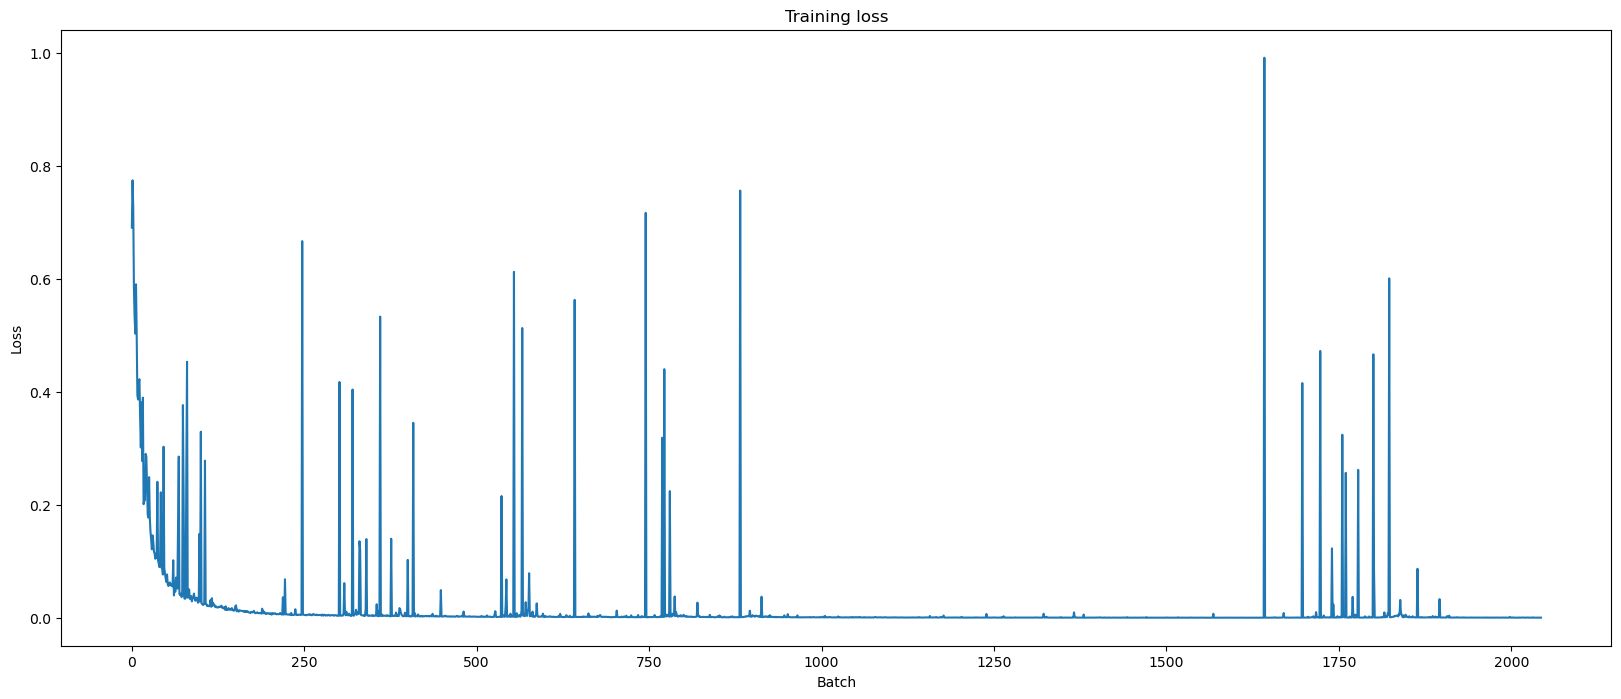

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()